## Music Recommender System

## Imports

In [1965]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sentence_transformers import SentenceTransformer
import faiss

## Dataset Loading and Cleaning 

In [1966]:
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

In [1967]:
df.shape

(114000, 21)

In [1968]:
df.sample(5)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
105401,105401,4UNCSVU2mC94tO2g7gxizh,Justnormal,Graceland Drive,Graceland Drive,33,148466,False,0.603,0.446,...,-8.379,0,0.0382,0.949000,0.097800,0.3970,0.0894,79.980,4,study
33582,33582,022nJwdqNEHRazWpp55bWa,PXNDX,Panda MTV Unplugged (Live),Quinta Real - MTV Unplugged,38,245139,False,0.410,0.621,...,-8.465,1,0.0366,0.175000,0.000000,0.9150,0.5760,164.543,4,emo
25534,25534,3PG0utmvR1m2DEyfnIAOU1,Maze;Frankie Beverly,R&B For Kids,Golden Time Of Day - Single Edit/Remastered 2004,34,265066,False,0.577,0.582,...,-9.988,1,0.0693,0.775000,0.000002,0.0994,0.5770,98.877,4,disco
65921,65921,6boUblHda4QDKSGAM8wrxP,Dhanush,Pattas,Chill Bro,44,239989,False,0.730,0.904,...,-4.223,1,0.2470,0.180000,0.000348,0.1210,0.4640,160.070,4,k-pop
83332,83332,6zn1Ggk5bUGpt22fGJQwpz,Alexander Popov;Luminn;DEXTER KING,Constancy,Constancy,38,194307,False,0.469,0.983,...,-2.944,0,0.0433,0.000938,0.800000,0.1520,0.0900,130.039,4,progressive-house


In [1969]:
df.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [1970]:
df = df.dropna()

**converting all string columns into lower case for better handling**

In [1971]:
str_columns = df.select_dtypes(include='object').columns
df[str_columns] = df[str_columns].map(lambda x: str(x).lower())

**Removing non-english characters and strings withing parenthesis**

In [1972]:
def remove_non_english(txt):
    if re.search(r"[^a-zA-Z0-9\(\)\s\-']", txt):
        return '' 
    txt = re.sub(r"\s*\([^)]*\)", "", txt) 
    return txt.strip()

df['track_name'] = df['track_name'].apply(remove_non_english)
df['album_name'] = df['album_name'].apply(remove_non_english)

In [1973]:
df = df[df['album_name'].str.strip() != '']
df = df[df['track_name'].str.strip() != '']

In [1974]:
df['artists'] = df['artists'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\(\)\s,\-;]', '', x))
df = df[df['artists'].str.strip() != '']

**dropping the duplicate records where `track_name` and `artist_name` are same** 

In [1975]:
df = df.drop_duplicates(subset=['track_name', 'artists'], keep='first')

**Splitting the `artist` column into a list containing the artists**

In [1976]:
df['artists'] = df['artists'].apply(lambda x: re.split(r'[;,]', x))

**Converting the `duration` column from milisecond to second**

In [1977]:
df['duration_ms'] = df['duration_ms']/1000
df.rename(columns={'duration_ms': 'duration'}, inplace=True)

In [1978]:
df = df.drop(['Unnamed: 0','track_id'],axis=1)

In [1979]:
df.sample(5)

,artists,album_name,track_name,popularity,duration,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
51569,[kodak black],totally rap,super gremlin,0,200.547,True,0.825,0.4140,2,-6.634,1,0.1440,0.002650,0.000000,0.3570,0.1060,72.993,4,hip-hop
2263,[neon trees],christmas top hits 2022,holiday rock,0,177.345,False,0.529,0.8180,6,-6.622,1,0.0400,0.000065,0.000000,0.3540,0.6840,148.173,4,alt-rock
18701,[jeff allen],three word vocabulary,therapy,22,78.480,False,0.620,0.5530,1,-17.269,1,0.9260,0.650000,0.000000,0.9560,0.3010,112.622,5,comedy
58551,[marilyn manson],the pale emperor,the mephistopheles of los angeles,44,297.168,False,0.625,0.9080,2,-4.080,1,0.0896,0.000201,0.000305,0.0987,0.1990,124.997,4,industrial
101000,[huma],ons,ons,71,193.239,False,0.111,0.0185,0,-32.335,1,0.0424,0.957000,0.940000,0.0870,0.0459,76.153,3,sleep


**final dataframe shape after cleaning**

In [1980]:
df.shape

(50978, 19)

## EDA

**Plotting the popularity scores of the top 25 songs helps in understanding which tracks are the most popular in the dataset.**

In [1981]:
top25_songs = df.sort_values(by='popularity',ascending=False)

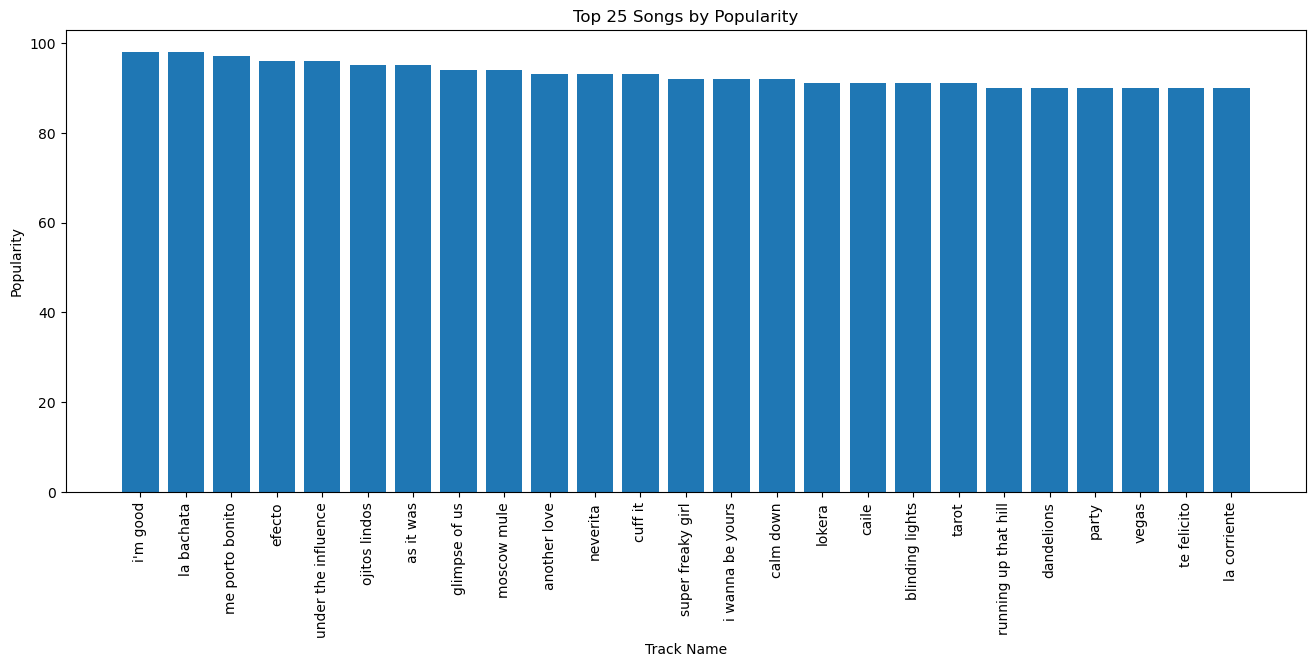

In [1982]:
plt.figure(figsize=(16,6))
plt.bar(top25_songs['track_name'][:25], top25_songs['popularity'][:25])
plt.xlabel('Track Name')
plt.ylabel('Popularity')
plt.title('Top 25 Songs by Popularity')
plt.xticks(rotation=90)
plt.show()

**Expanding the list of artists into separate rows using `explode`, and removing any empty artist entries by stripping whitespace and filtering out empty strings.**

In [1983]:
artists = df.explode('artists')
artists = artists[artists['artists'].str.strip() != '']

**Grouping tracks by artist and computing the mean popularity and track count for each artist.  
Sorting by track count to identify the most frequent contributors.**

In [1984]:
artist_stats = artists.groupby('artists')['popularity'].agg(['mean', 'count']).sort_values(by='count', ascending=False).reset_index()
artist_stats

,artists,mean,count
0,pritam,54.535398,226
1,george jones,15.746544,217
2,arijit singh,58.401316,152
3,hank williams,15.775510,147
4,yuvan shankar raja,50.590551,127
...,...,...,...
21507,miwa,57.000000,1
21508,miwata,26.000000,1
21509,mixed by dillinja,19.000000,1
21510,mixed by doc scott,17.000000,1


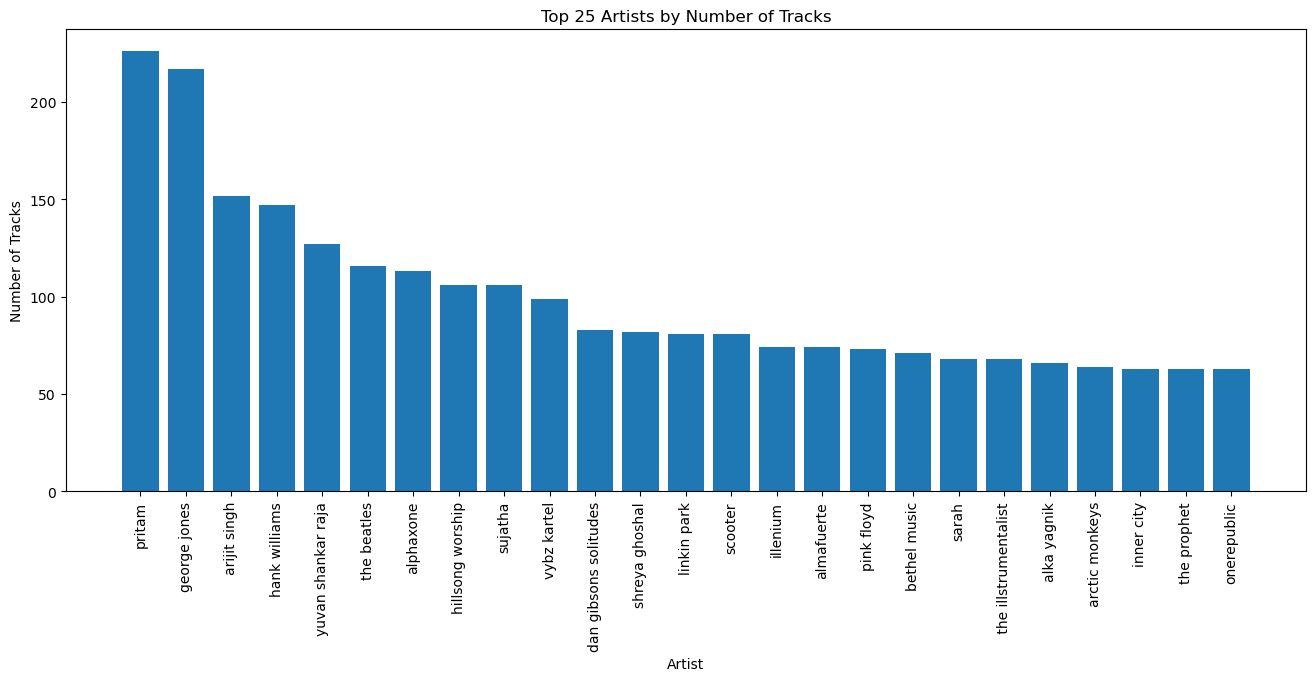

In [1985]:
plt.figure(figsize=(16,6))
plt.bar(artist_stats['artists'][:25], artist_stats['count'][:25])
plt.xlabel('Artist')
plt.ylabel('Number of Tracks')
plt.title('Top 25 Artists by Number of Tracks')
plt.xticks(rotation=90)
plt.show()

**Computing the Bayesian average popularity score for each artist  
by balancing the artist’s own average with the global mean using a prior of 100.  
This prevents artists with very few tracks from having skewed popularity values.**

In [1986]:
global_mean = df['popularity'].mean()

prior = 100

artist_stats['bayesian_avg'] = (
    (artist_stats['mean'] * artist_stats['count'] + global_mean * prior)
    / (artist_stats['count'] + prior)
)

In [1987]:
artist_stats = artist_stats.sort_values(by='bayesian_avg',ascending=False)
top_25_artists = artist_stats[:25].copy()

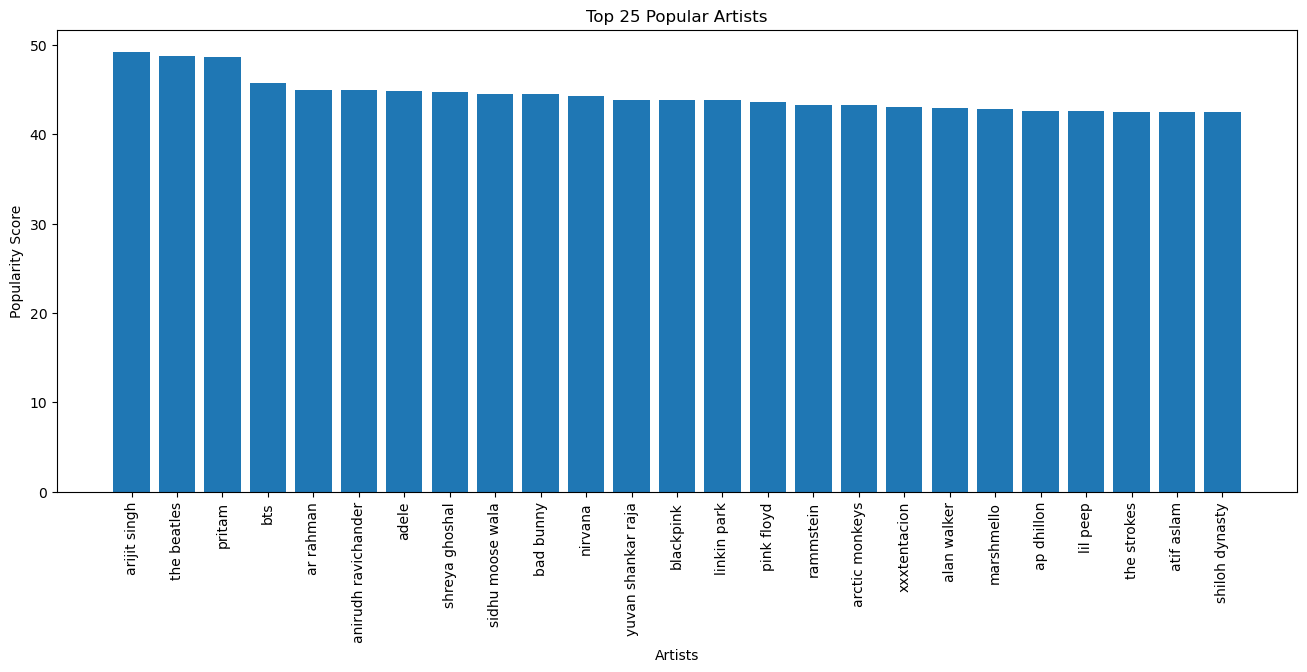

In [1988]:
plt.figure(figsize=(16,6))
plt.bar(top_25_artists['artists'][:25],top_25_artists['bayesian_avg'][:25])
plt.xticks(rotation=90);
plt.title('Top 25 Popular Artists')
plt.xlabel('Artists')
plt.ylabel('Popularity Score');

**`duration` represents the length of a track**

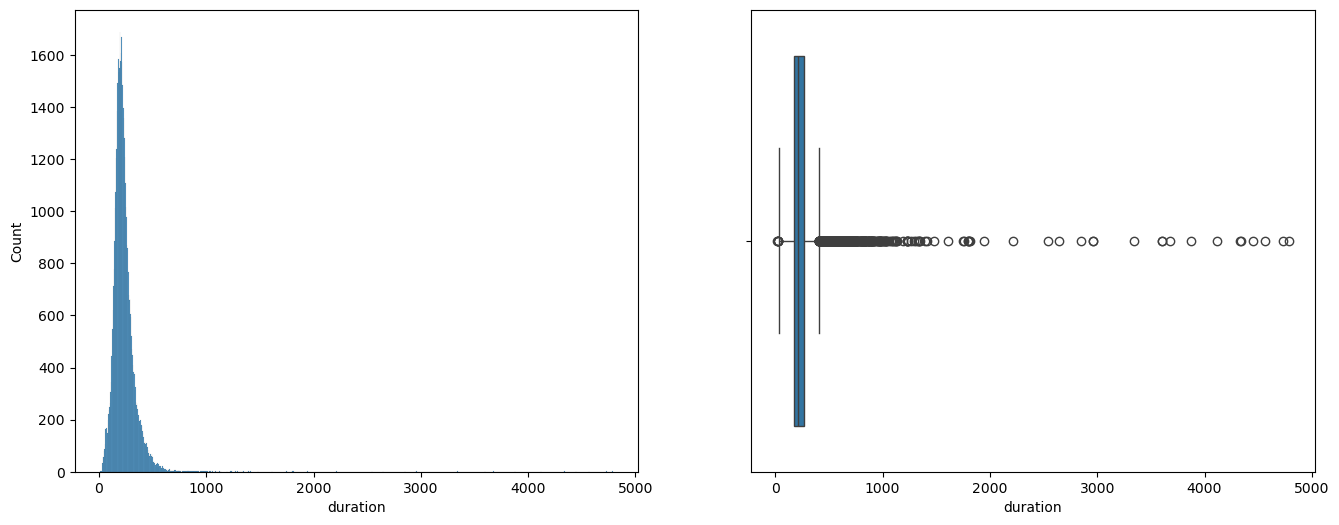

In [1989]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
sns.histplot(data=df,x='duration',ax=ax[0])
sns.boxplot(data=df,x='duration',ax=ax[1]);

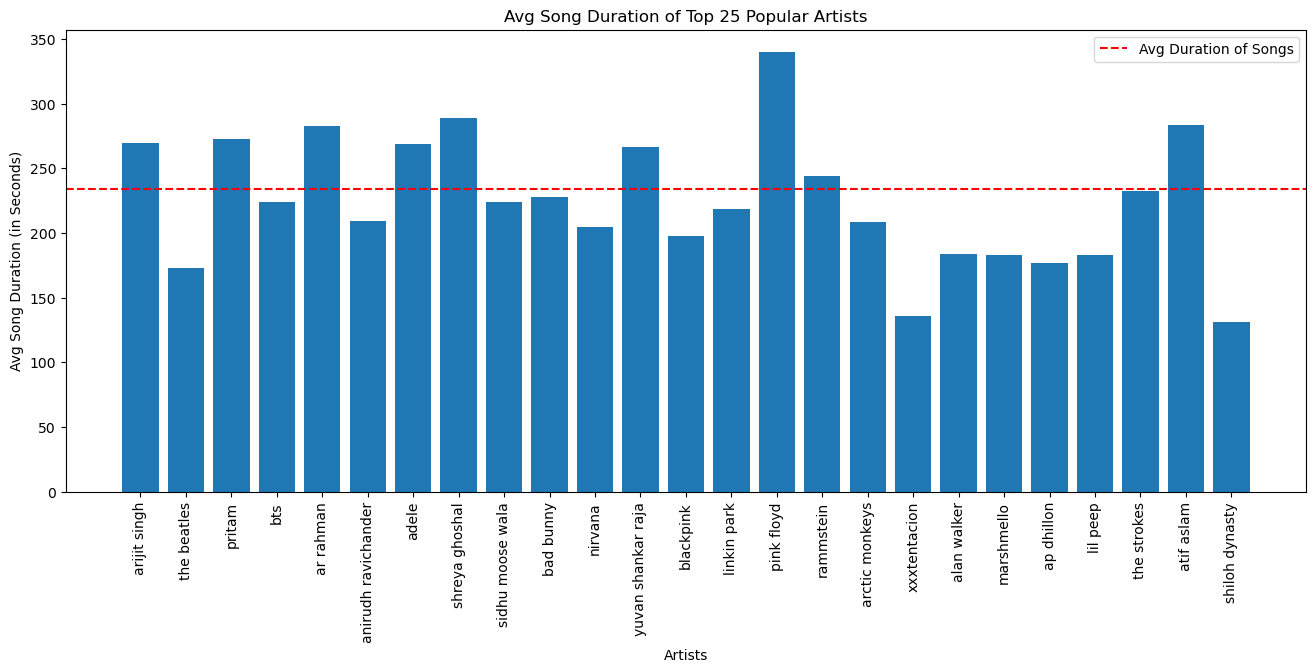

In [1990]:
artist_avg_duration = artists.groupby('artists')['duration'].mean()
top_25_artists['avg_duration'] = top_25_artists['artists'].map(artist_avg_duration)

plt.figure(figsize=(16,6))
plt.bar(top_25_artists['artists'], top_25_artists['avg_duration'])
plt.axhline(y=artists['duration'].mean(), ls='--', color='red', label='Avg Duration of Songs')
plt.xticks(rotation=90)
plt.xlabel('Artists')
plt.ylabel('Avg Song Duration (in Seconds)')
plt.title('Avg Song Duration of Top 25 Popular Artists')
plt.legend()
plt.show()


**Visualizing Count of Explicit Content in Tracks**

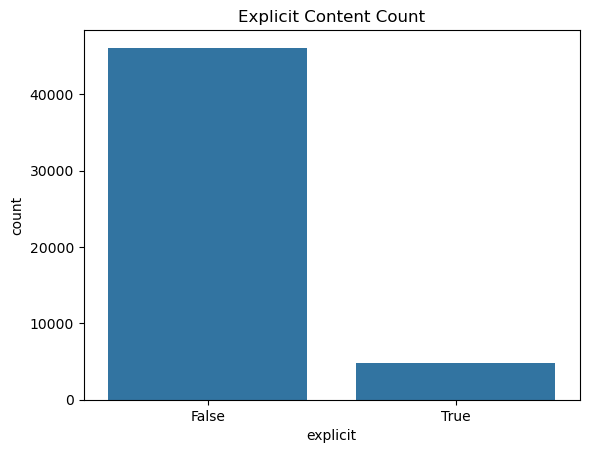

In [1991]:
sns.countplot(data=df,x='explicit')
plt.title('Explicit Content Count');

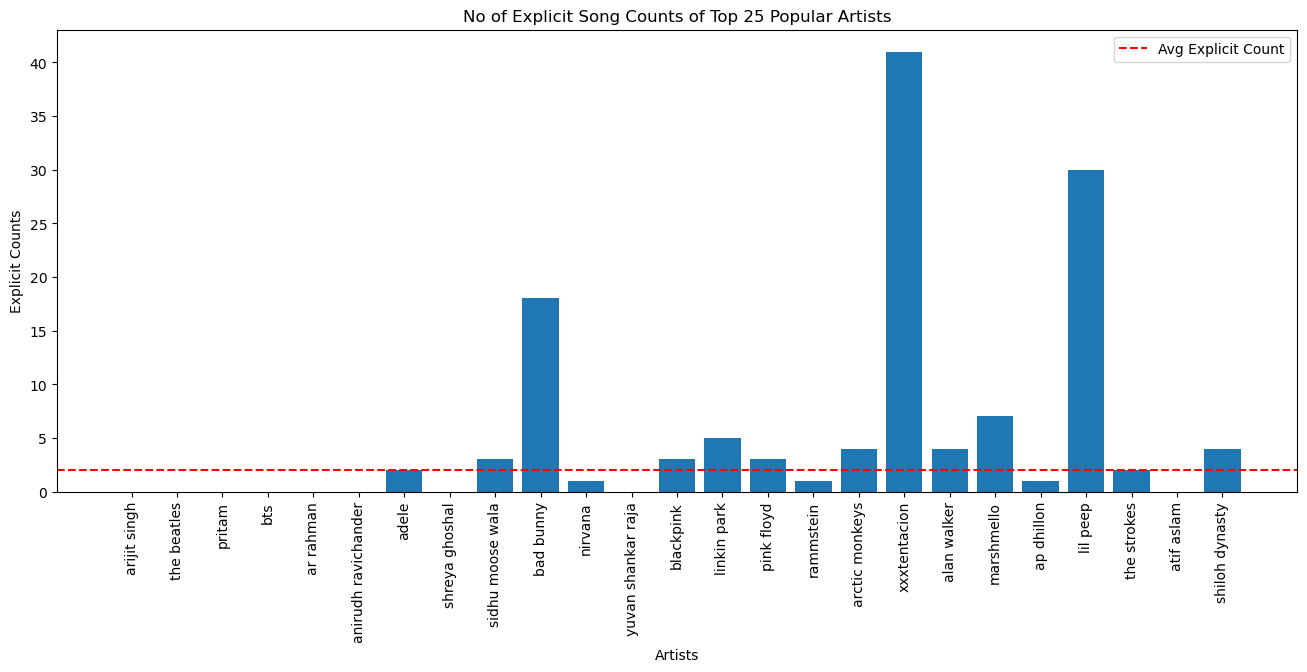

In [1992]:
explicit = artists[artists['explicit']==True].groupby('artists')['explicit'].size()
explicit_mean_count = explicit.mean()
top_25_artists.loc[:, 'n_explicit'] = top_25_artists['artists'].map(explicit)
top_25_artists.loc[:, 'n_explicit'] = top_25_artists['n_explicit'].fillna(0)

plt.figure(figsize=(16,6))
plt.bar(top_25_artists['artists'],top_25_artists['n_explicit'])
plt.axhline(y=explicit_mean_count, ls='--', color='red', label='Avg Explicit Count')
plt.xticks(rotation=90)
plt.xlabel('Artists')
plt.ylabel('Explicit Counts')
plt.title('No of Explicit Song Counts of Top 25 Popular Artists')
plt.legend();

**`Danceability` measures how suitable a track is for dancing based on tempo, rhythm stability, beat strength, and overall regularity. Values range from 0 (least danceable) to 1 (most danceable).**

<Axes: xlabel='danceability'>

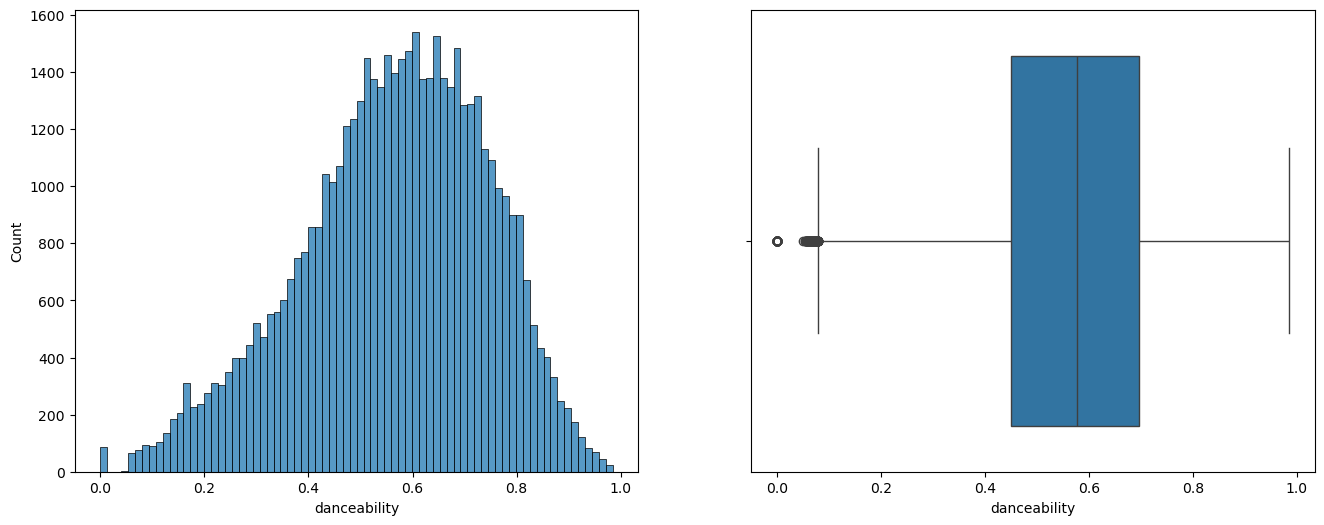

In [1993]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
sns.histplot(data=df,x='danceability',ax=ax[0])
sns.boxplot(data=df,x='danceability',ax=ax[1])

**`Energy` represents a perceptual measure of intensity and activity in a track. High energy tracks feel fast, loud, and noisy, while low energy tracks feel calm or mellow. Values range from 0 (low energy) to 1 (high energy).**

<Axes: xlabel='energy'>

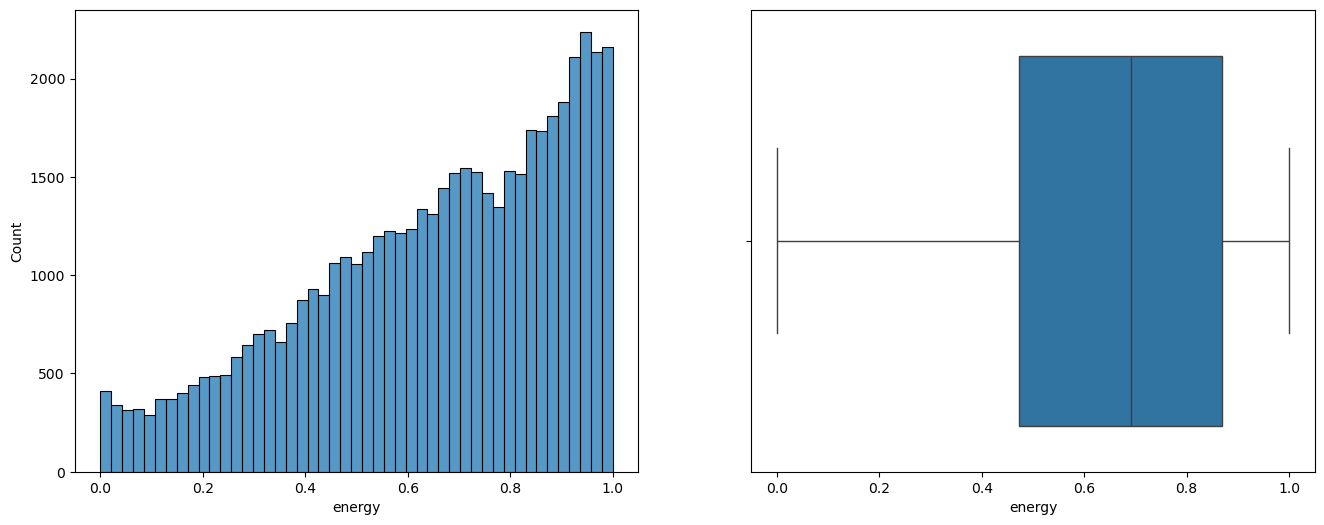

In [1994]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
sns.histplot(data=df,x='energy',ax=ax[0])
sns.boxplot(data=df,x='energy',ax=ax[1])

**`Liveness` indicates the presence of an audience in the recording. Higher values suggest a live performance, while lower values imply a studio recording. Values range from 0 to 1.**

<Axes: xlabel='liveness'>

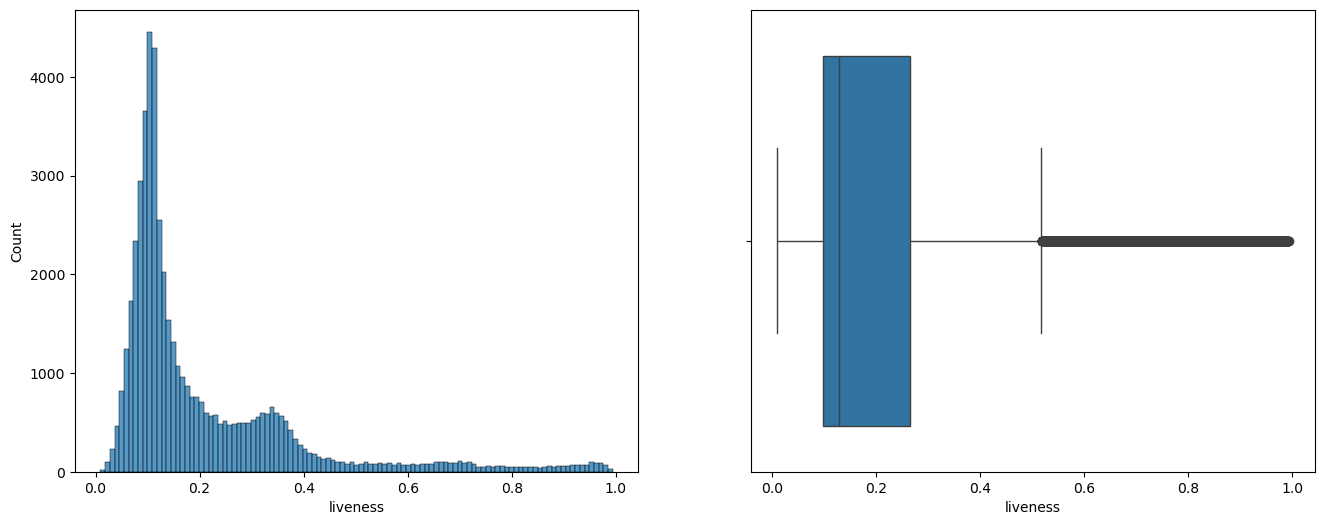

In [1995]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
sns.histplot(data=df,x='liveness',ax=ax[0])
sns.boxplot(data=df,x='liveness',ax=ax[1])

**`valence` measures the musical positiveness conveyed by a track. Higher values indicate more positive, happy, or cheerful songs, while lower values indicate more negative or sad tones. The values range from 0 to 1.**

<Axes: xlabel='valence'>

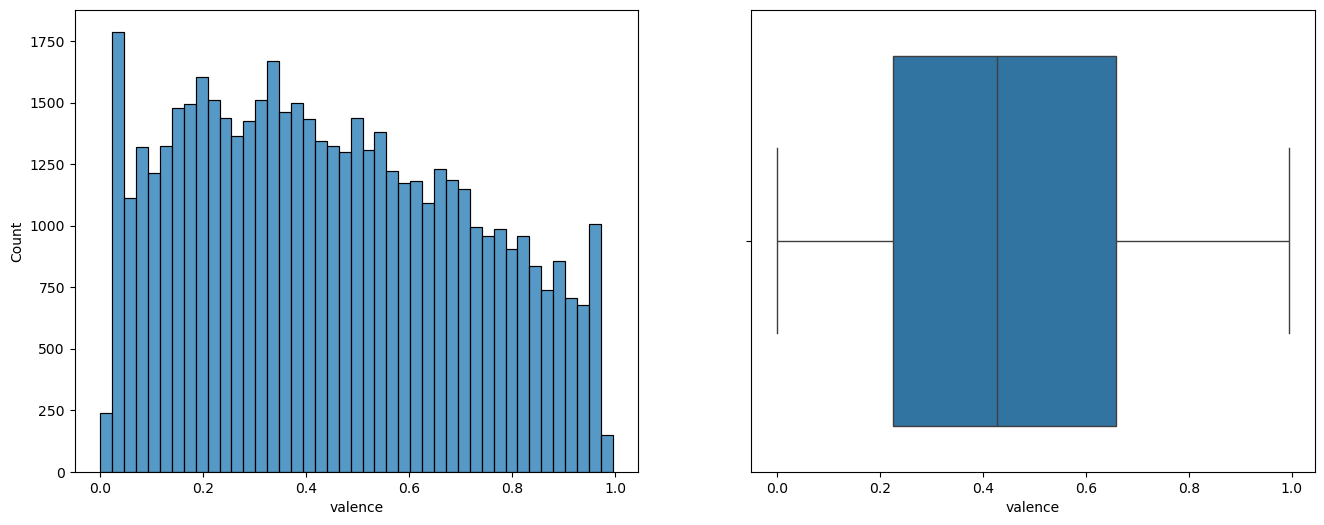

In [1996]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
sns.histplot(data=df,x='valence',ax=ax[0])
sns.boxplot(data=df,x='valence',ax=ax[1])

**Grouping by `artists` and calculating the average values for the audio features `danceability`, `energy`, `liveness`, and `valence`. Using these features, plotting radar charts to compare the energy profiles of the top 25 artists. Each radar chart shows normalized values of the four features, highlighting different energy characteristics across artists.**

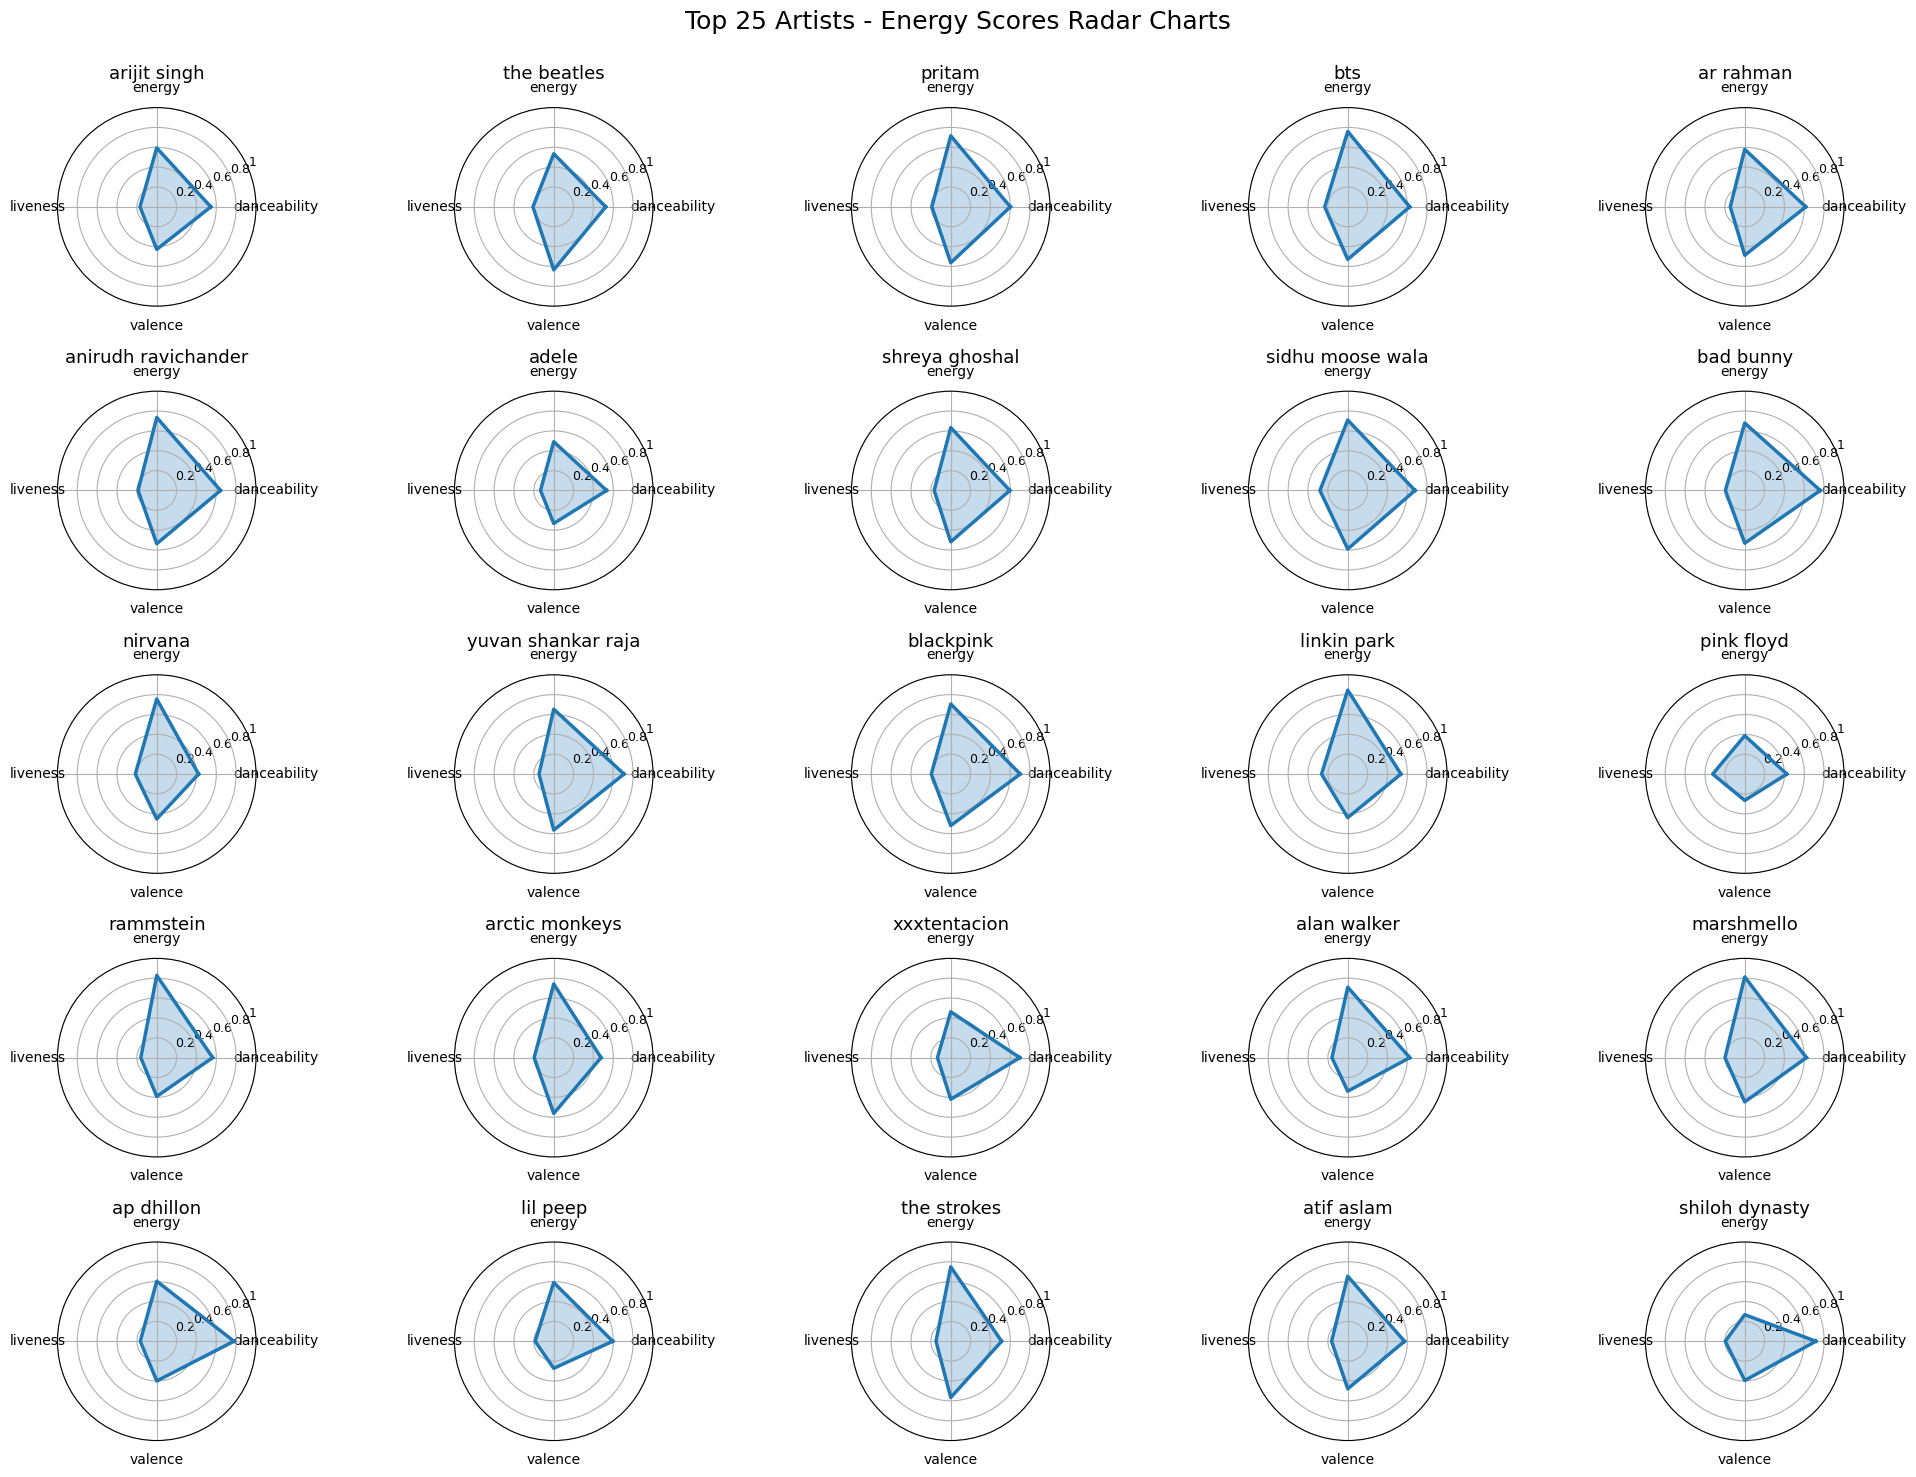

In [1997]:
artist_energy_feats = artists.groupby('artists')[['danceability', 'energy', 'liveness', 'valence']].mean()
top_15_artists = top_25_artists.join(artist_energy_feats, on='artists')

energy_score = ['danceability', 'energy', 'liveness', 'valence']
N = len(energy_score)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

rows, cols = 5, 5
fig, axs = plt.subplots(rows, cols, subplot_kw=dict(polar=True), figsize=(20, 16))
axs = axs.flatten()

def normalize(row):
    return [row[cat] for cat in energy_score]


for i, (idx, row) in enumerate(top_15_artists.head(rows * cols).iterrows()):
    ax = axs[i]
    artist = row['artists']
    
    values = normalize(row)
    values += values[:1]  
    
    ax.plot(angles, values, linewidth=2.5, linestyle='solid', label=artist)
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(artist, size=13, y=1.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(energy_score, fontsize=10)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1'], fontsize=9)
    ax.set_ylim(0, 1)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Top 25 Artists - Energy Scores Radar Charts', fontsize=18, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 

In [1998]:
print("Artists for Max values across the 4 Audio Features ('danceability', 'energy', 'liveness', 'valence'):\n")

for feature in ['danceability', 'energy', 'liveness', 'valence']:
    max_artist = artist_energy_feats[feature].idxmax()
    max_value = artist_energy_feats[feature].max()
    
    print(f"{feature.title():<12} --> {max_artist:<25} | Score: {max_value:.3f}")

Artists for Max values across the 4 Audio Features ('danceability', 'energy', 'liveness', 'valence'):

Danceability --> casper  colta             | Score: 0.978
Energy       --> amduscia                  | Score: 1.000
Liveness     --> israel salazar            | Score: 0.988
Valence      --> ottawan                   | Score: 0.992


**A musical note represents a specific pitch or frequency in music, corresponding to a distinct sound. Notes are the building blocks of melodies and harmonies in songs. In the dataset, the `key` column indicates the musical key or note of a track, which helps understand the tonal characteristics used by artists.**

| Key | Note  |
| --- | ----- |
| 0   | C     |
| 1   | C♯/D♭ |
| 2   | D     |
| 3   | D♯/E♭ |
| 4   | E     |
| 5   | F     |
| 6   | F♯/G♭ |
| 7   | G     |
| 8   | G♯/A♭ |
| 9   | A     |
| 10  | A♯/B♭ |
| 11  | B     |

**Creating a pivot table that counts the number of tracks each artist has produced in each musical key (`key` column). Filtering this table to include only the top 25 artists, then visualizing it using a heatmap to show how frequently each musical key is used by these artists.**

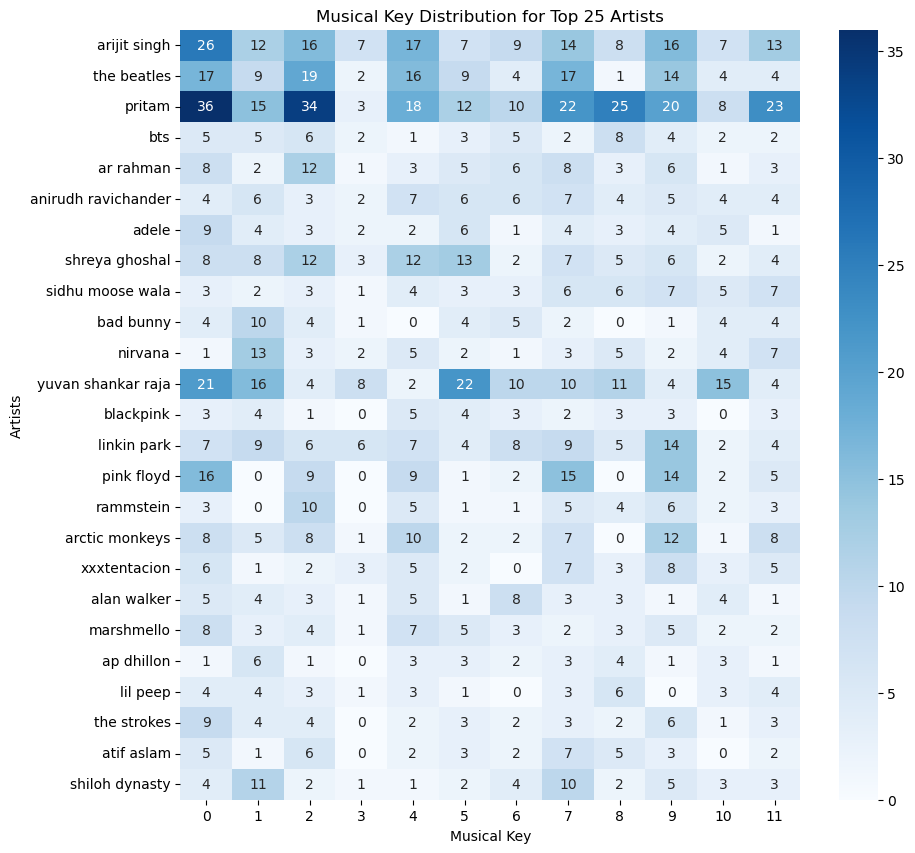

In [1999]:
musical_notes = artists.pivot_table(
    index='artists',
    columns='key',
    values='track_name',
    aggfunc='count',
    fill_value=0  
)

musical_notes_top25 = musical_notes.loc[top_25_artists['artists']]

plt.figure(figsize=(10,10))
sns.heatmap(musical_notes_top25, annot=True, cmap='Blues')
plt.title('Musical Key Distribution for Top 25 Artists')
plt.xlabel('Musical Key')
plt.ylabel('Artists')
plt.show()

**Musical mode refers to the type of scale that forms the basis of a musical composition, usually categorized as major or minor. Modes affect the mood and emotional tone of the music. In the dataset, the `mode` column indicates whether a track is in a major (1) or minor (0) key.**

- 0 = Minor (often sounds sad or melancholic)
- 1 = Major (often sounds happy or bright)

**The following code examines the distribution of major and minor modes across the top 25 artists, offering insights into their stylistic tendencies.**

<Axes: xlabel='mode', ylabel='artists'>

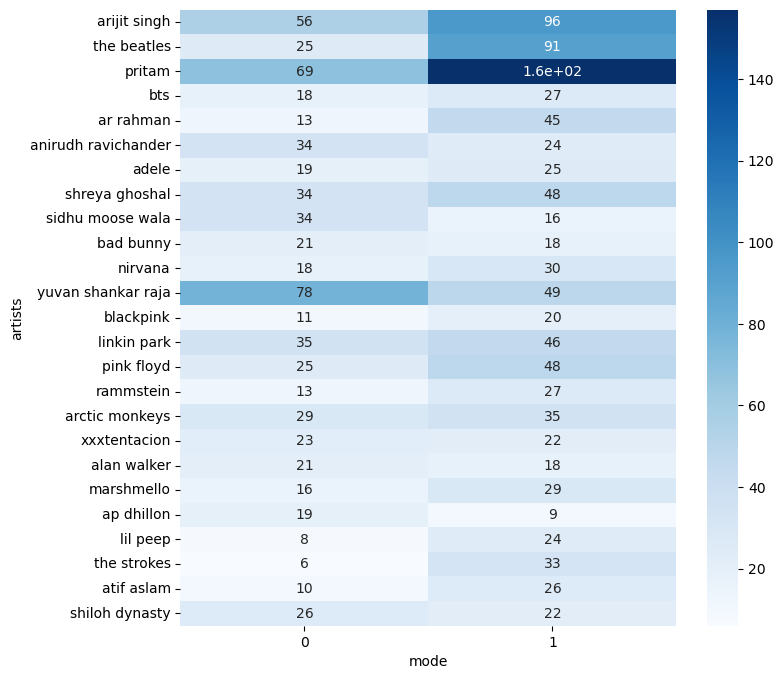

In [2000]:
mode = artists.pivot_table(
    index='artists',
    columns='mode',
    values='track_name',
    aggfunc='count',
    fill_value=0  
)


mode_top25 = mode.loc[top_25_artists['artists']]
plt.figure(figsize=(8,8))
sns.heatmap(mode_top25,annot=True,cmap='Blues')

**Music scores such as `speechiness`, `acousticness`, and `instrumentalness` describe different audio characteristics of tracks.**

- **`speechiness` measures the presence of spoken words in a track, with higher values indicating more spoken content.**
- **`acousticness` estimates the likelihood that a track is acoustic, with higher values indicating more acoustic qualities.**
- **`instrumentalness` predicts whether a track is instrumental (no vocals), with higher values indicating more instrumental content.**

**The following radar charts visualize the average music scores for the top 25 artists, highlighting their unique audio signatures.**

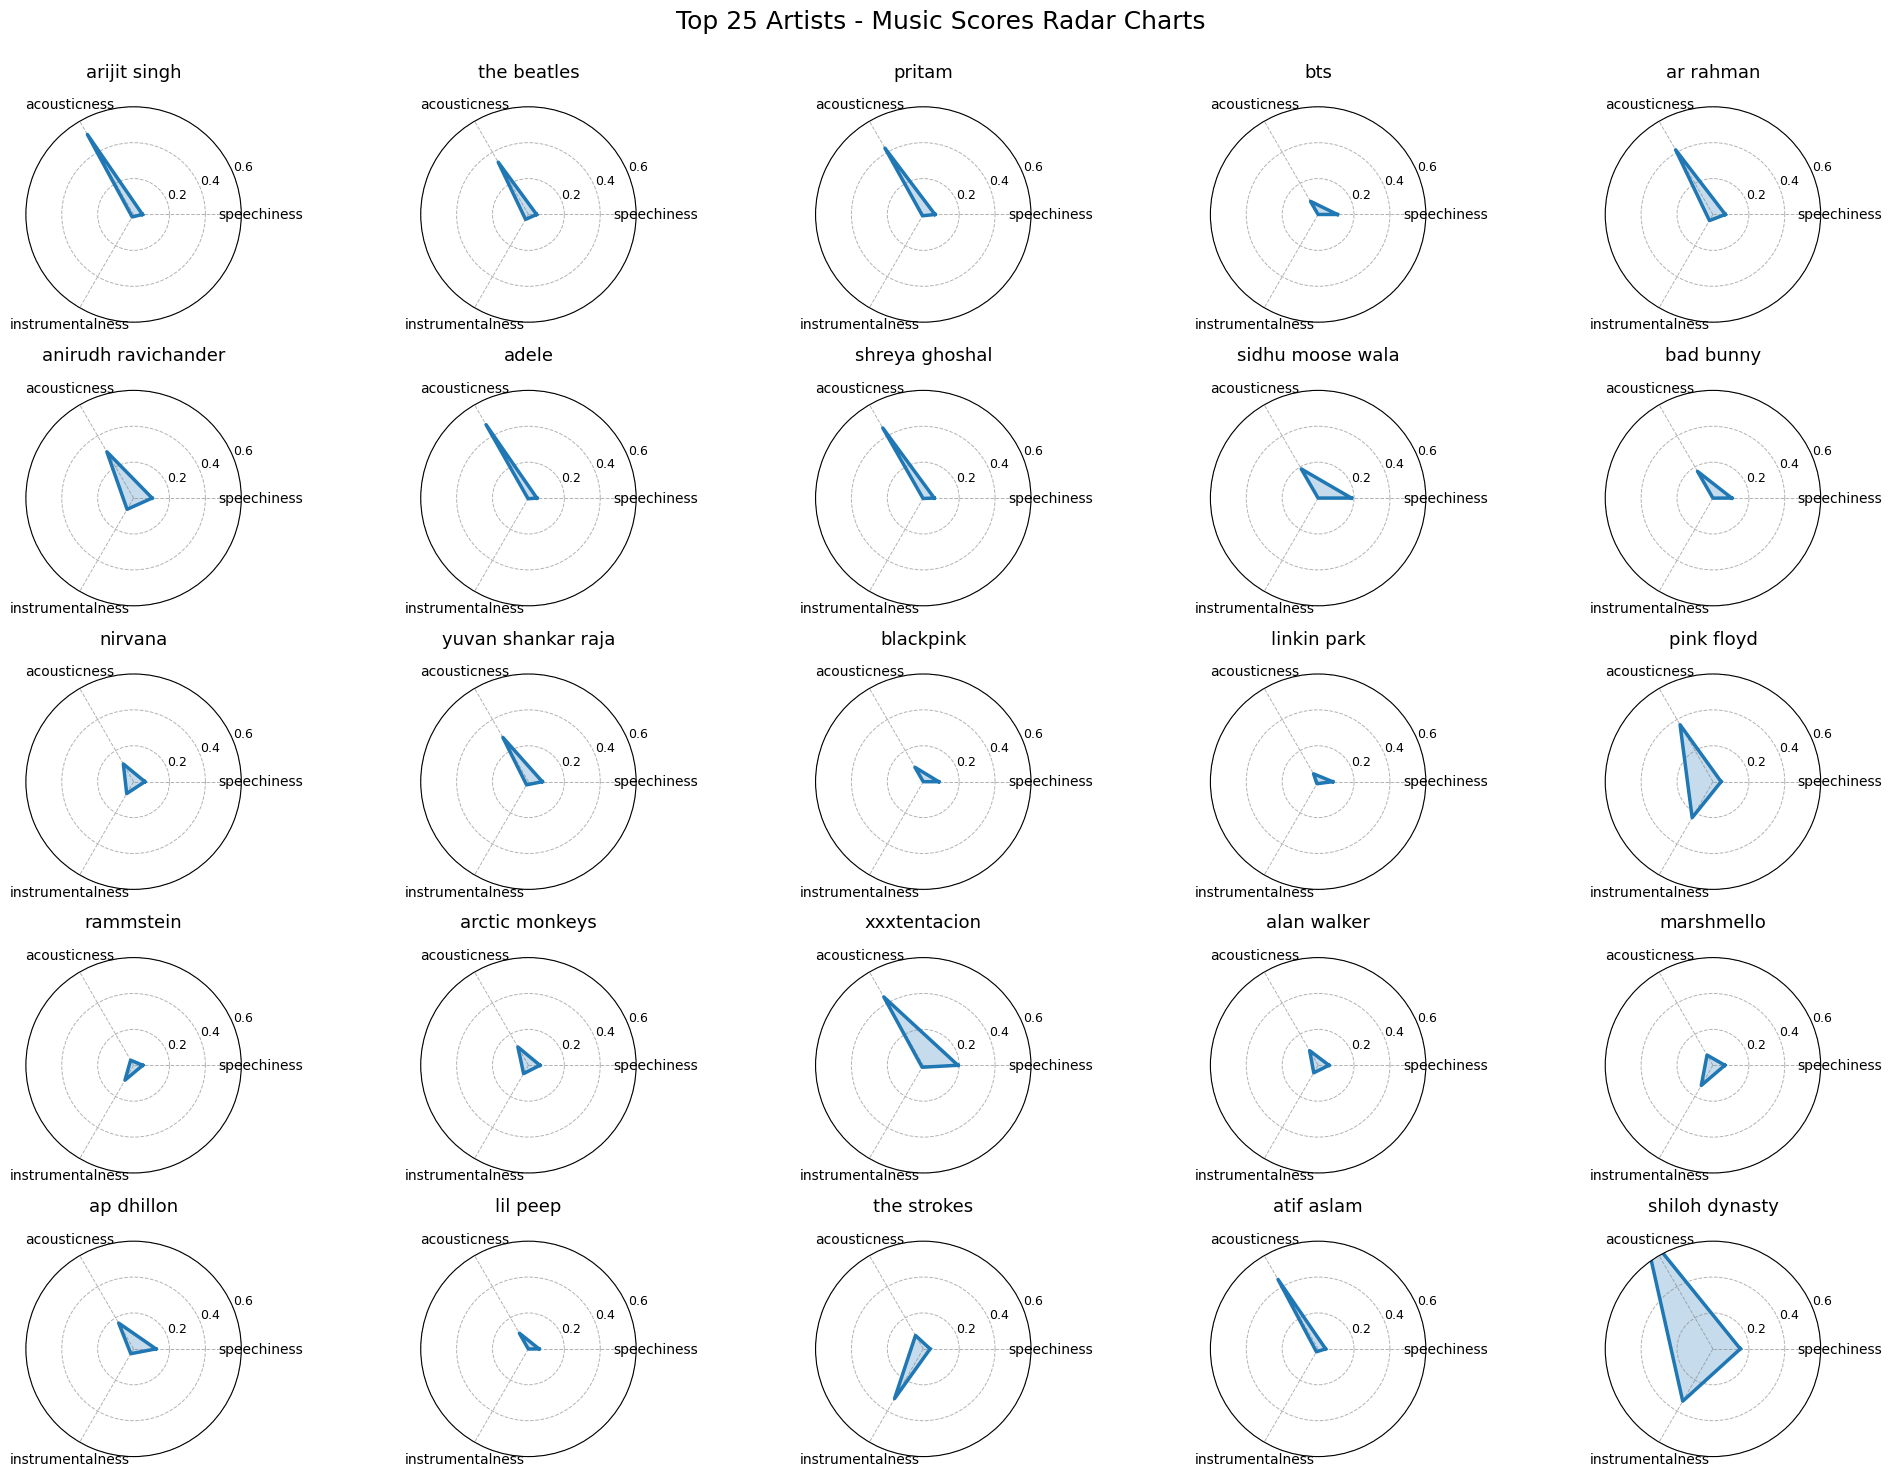

In [2001]:
music_scores = artists.groupby('artists')[['speechiness', 'acousticness', 'instrumentalness']].mean().reset_index()
top_25_artists = top_25_artists.merge(music_scores, on='artists', how='left')

music_score = ['speechiness', 'acousticness', 'instrumentalness']
N = len(music_score)

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

rows, cols = 5, 5
fig, axs = plt.subplots(rows, cols, subplot_kw=dict(polar=True), figsize=(20, 16))
axs = axs.flatten()

def normalize(row):
    return [row[cat] for cat in music_score]

for i, (idx, row) in enumerate(top_25_artists.head(rows * cols).iterrows()):
    ax = axs[i]
    artist = row['artists']
    
    values = normalize(row)
    values += values[:1]  # close the radar chart
    
    # Plot and style
    ax.plot(angles, values, linewidth=2.5, linestyle='solid', label=artist)
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(artist, size=13, y=1.1)
    
    # Set axis labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(music_score, fontsize=10)
    
    # Smaller circles, up to 0.6 max
    ax.set_yticks([0.2, 0.4, 0.6])
    ax.set_yticklabels(['0.2', '0.4', '0.6'], fontsize=9)
    ax.set_ylim(0, 0.6)
    
    # Optional: Make gridlines a bit lighter for clarity
    ax.grid(color='gray', linestyle='--', linewidth=0.7, alpha=0.6)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add title and layout
plt.suptitle('Top 25 Artists - Music Scores Radar Charts', fontsize=18, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [2002]:
print("Artists for Max values across the 3 Audio Features ('speechiness', 'acousticness', 'instrumentalness'):\n")

for feature in ['speechiness', 'acousticness', 'instrumentalness']:
    max_artist = music_scores.set_index('artists')[feature].idxmax()
    max_value = music_scores[feature].max()
    
    print(f"{feature.title():<12} --> {max_artist:<25} | Score: {max_value:.3f}")

Artists for Max values across the 3 Audio Features ('speechiness', 'acousticness', 'instrumentalness'):

Speechiness  --> jay mohr                  | Score: 0.960
Acousticness --> aaren hughes              | Score: 0.996
Instrumentalness --> sleep miracle             | Score: 1.000


In [2003]:
loud_tempo = artists.groupby('artists')[['loudness','tempo']].mean().reset_index()
top_25_artists = top_25_artists.merge(loud_tempo, on='artists', how='left')

**`Loudness` is an audio feature that measures the overall perceived volume of a track in decibels (dB).**
- The closer the loudness is to 0 dB, the louder the sound.
- The more negative the value, the quieter the sound.

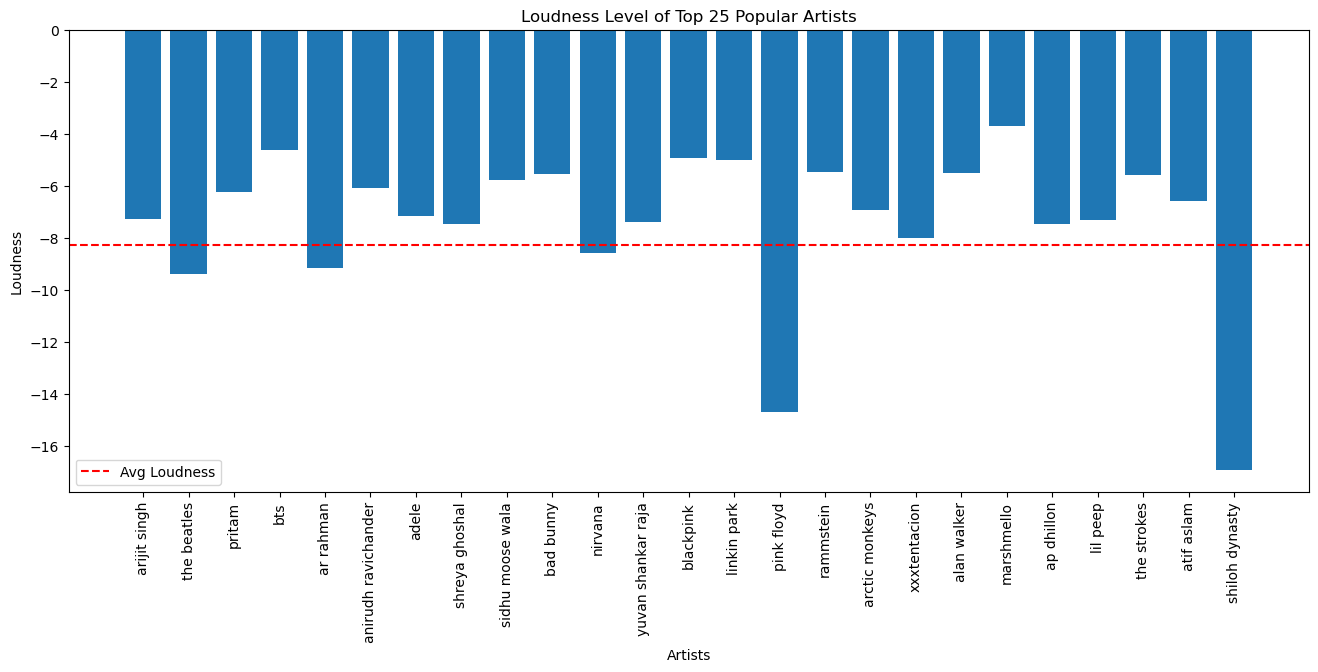

In [2004]:
plt.figure(figsize=(16,6))
plt.bar(top_25_artists['artists'],top_25_artists['loudness'])
plt.axhline(y=loud_tempo['loudness'].mean(), ls='--', color='red', label='Avg Loudness')
plt.xticks(rotation=90)
plt.xlabel('Artists')
plt.ylabel('Loudness')
plt.title('Loudness Level of Top 25 Popular Artists')
plt.legend();

**`Tempo` is an audio feature representing the speed or pace of a track, measured in beats per minute (BPM).**
- A higher tempo means the music is faster.
- A lower tempo means the music is slower.

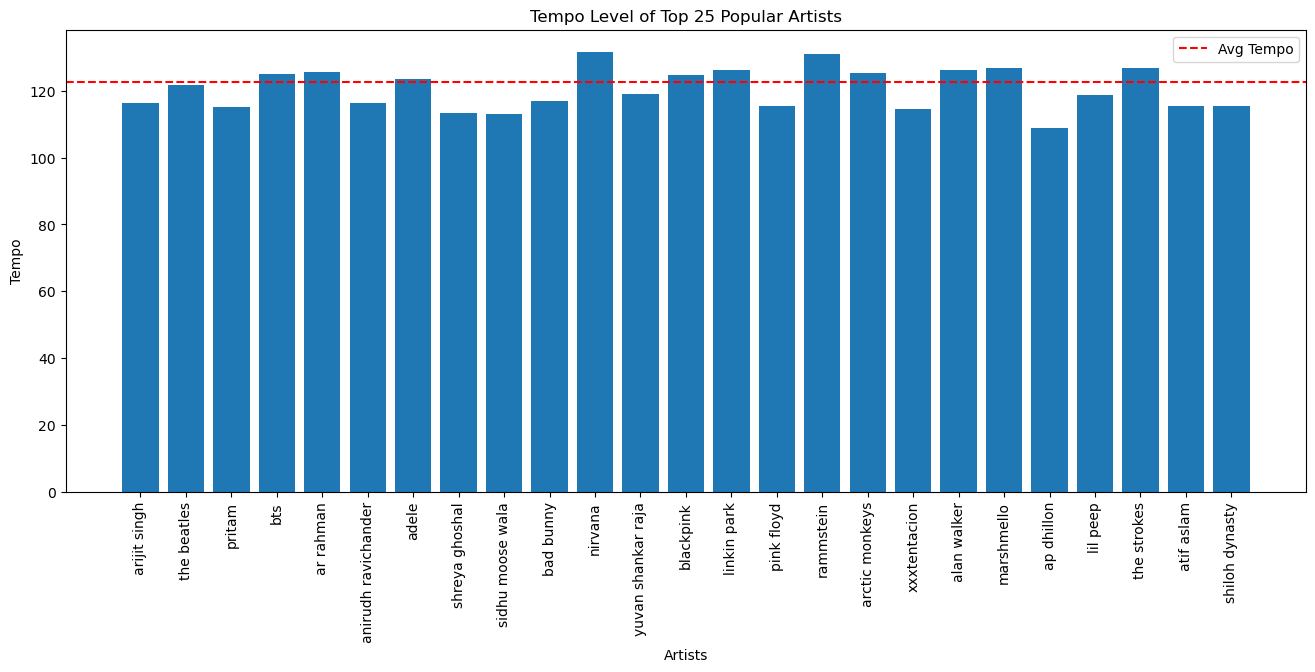

In [2005]:
plt.figure(figsize=(16,6))
plt.bar(top_25_artists['artists'],top_25_artists['tempo'])
plt.axhline(y=loud_tempo['tempo'].mean(), ls='--', color='red', label='Avg Tempo')
plt.xticks(rotation=90)
plt.xlabel('Artists')
plt.ylabel('Tempo')
plt.title('Tempo Level of Top 25 Popular Artists')
plt.legend();

**`track_genre` refers to the category or style of music associated with each track.**

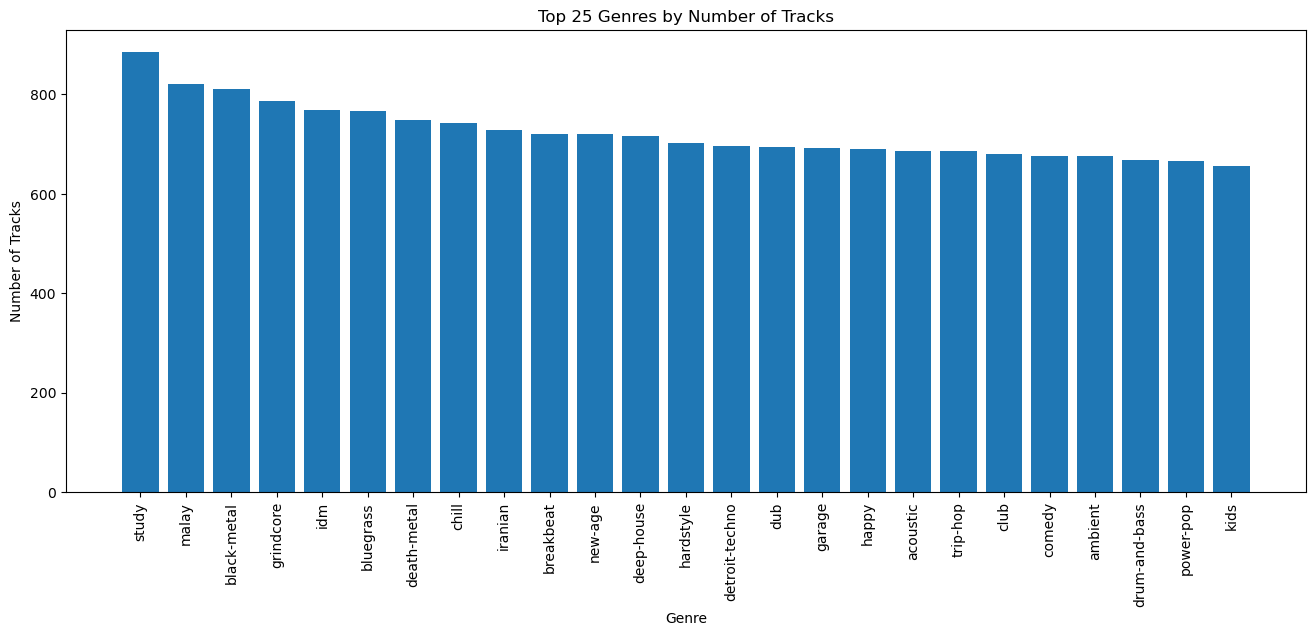

In [2006]:
genre_songs_count = df['track_genre'].value_counts().reset_index().sort_values(by='count',ascending=False)

plt.figure(figsize=(16,6))
plt.bar(genre_songs_count['track_genre'][:25], genre_songs_count['count'][:25])
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Tracks')
plt.title('Top 25 Genres by Number of Tracks')
plt.show()

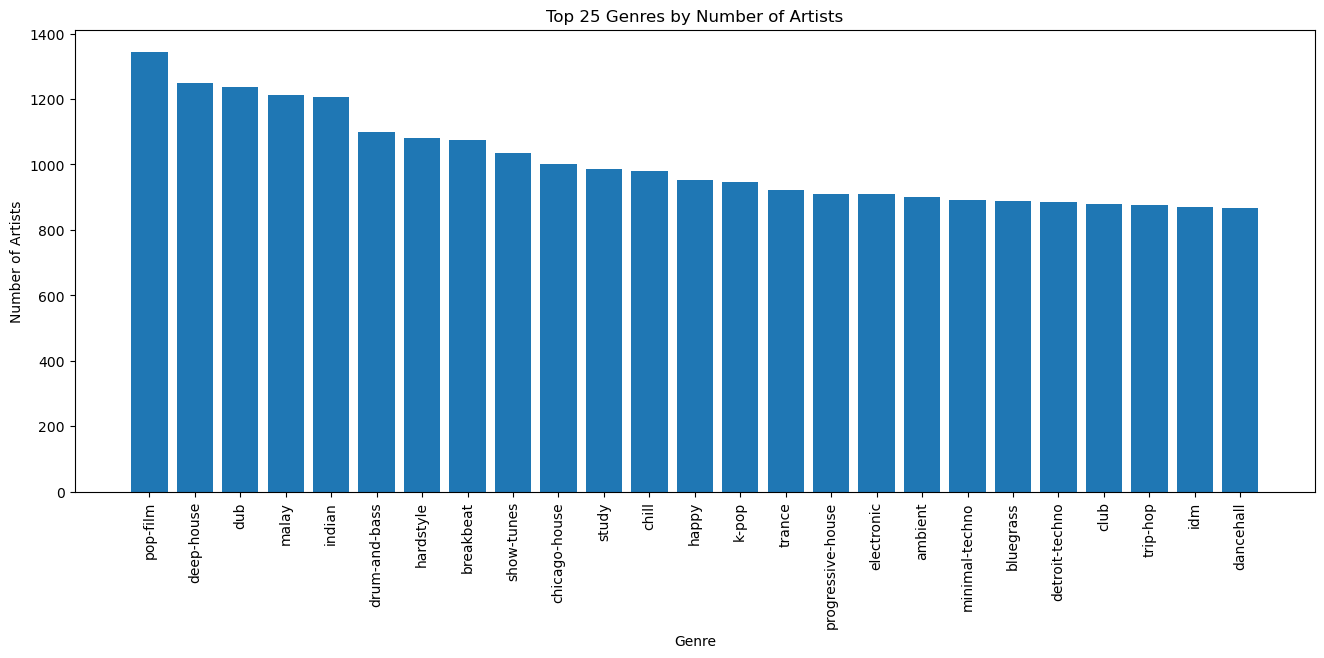

In [2007]:
genre_artist_count = artists.groupby('track_genre')['artists'].count().reset_index().sort_values(by='artists',ascending=False)

plt.figure(figsize=(16,6))
plt.bar(genre_artist_count['track_genre'][:25], genre_artist_count['artists'][:25])
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of Artists')
plt.title('Top 25 Genres by Number of Artists')
plt.show()

In [2008]:
genre_by_artist = artists.pivot_table(
    index='artists',
    columns='track_genre',
    values='track_name',
    aggfunc='count',
    fill_value=0  
)

genre_top25art = genre_by_artist.loc[top_15_artists['artists']]
genre_top25art_nonzero = genre_top25art.loc[:, (genre_top25art != 0).any(axis=0)]

Text(0.5, 1.0, 'Genre Distribution of Top 25 Artists')

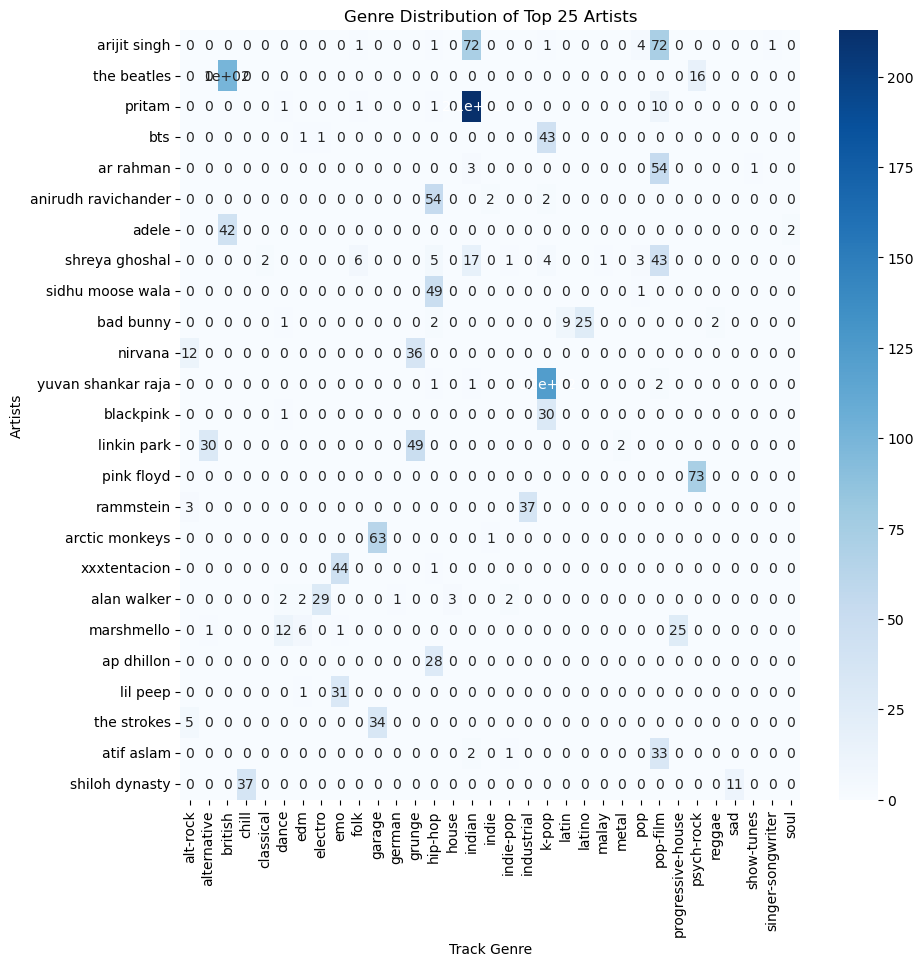

In [2009]:
plt.figure(figsize=(10,10))
sns.heatmap(genre_top25art_nonzero, cmap='Blues', annot=True)

plt.xlabel('Track Genre')
plt.ylabel('Artists')
plt.title('Genre Distribution of Top 25 Artists')

Time signature in music defines how beats are grouped in each measure (bar).

| Value | Interpreted Time Signature | Meaning                                                       |
| ----- | -------------------------- | ------------------------------------------------------------- |
| 4     | **4/4**                    | Most common in modern music (pop, rock, hip-hop, etc.)        |
| 3     | **3/4**                    | Waltz rhythm, 3 beats per bar                                 |
| 1     | **1/4**                    | Very rare; could be an error or very short rhythm cycle       |
| 5     | **5/4**                    | Unusual time, often used in jazz or progressive music         |
| 0     | **Unspecified / Missing**  | This likely indicates a **missing or invalid time signature** |


In [2010]:
sign = artists.groupby('artists')['time_signature'].mean().apply(np.floor).astype(int)
top_25_artists = top_25_artists.merge(sign, left_on='artists', right_index=True, how='inner')

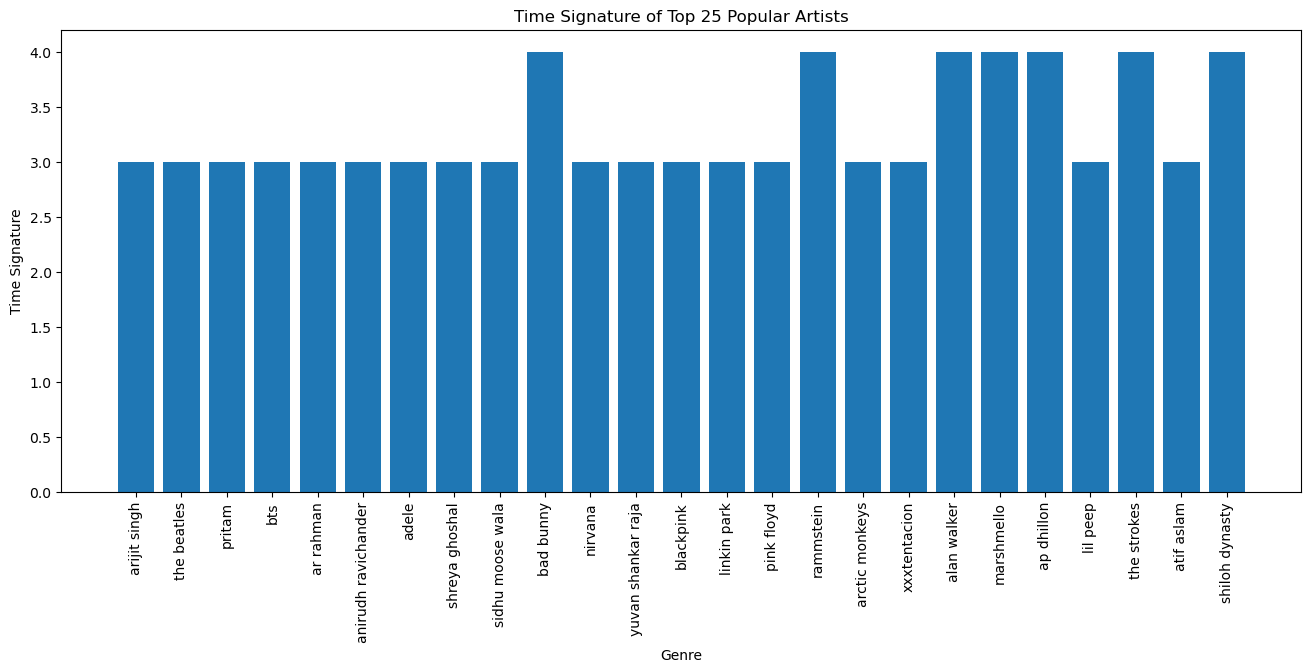

In [2011]:
plt.figure(figsize=(16,6))
plt.bar(top_25_artists['artists'],top_25_artists['time_signature'])
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Time Signature')
plt.title('Time Signature of Top 25 Popular Artists')
plt.show()

## Pre-Processing

In [2012]:
scaler = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False,drop='first') 

In [2013]:
df[['loudness', 'tempo', 'popularity','duration']] = scaler.fit_transform(df[['loudness', 'tempo', 'popularity','duration']])
artists[['loudness', 'tempo', 'popularity']] = scaler.fit_transform(artists[['loudness', 'tempo', 'popularity']])

In [2014]:
final_artist_df = artists.groupby('artists')[['popularity','danceability','energy','loudness','speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo']].mean().reset_index()

In [2015]:
final_artist_df.sample(5)

,artists,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
17781,snog,0.234694,0.661000,0.9380,0.830809,0.066000,0.00539,0.190000,0.327000,0.392000,0.537108
3468,charmian carr,0.530612,0.447400,0.1563,0.631645,0.045820,0.89200,0.000025,0.129740,0.355600,0.466862
14031,nithyasree mahadevan,0.438776,0.389667,0.5820,0.782975,0.093767,0.37290,0.003086,0.161467,0.458667,0.462255
13831,new times,0.622449,0.736000,0.4870,0.696872,0.033400,0.53300,0.000000,0.299000,0.581000,0.501496
15605,rahi,0.357143,0.257000,0.5780,0.799049,0.036100,0.71100,0.000001,0.146000,0.438000,0.602251


In [2016]:
final_songs_df = df[['artists', 'track_name', 'popularity', 'duration',
       'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'track_genre']].copy()

**Selecting categorical columns: `key`, `time_signature`, `mode`, `explicit`, and `track_genre`.**

**Applying One-Hot Encoding (OHE) to transform these categorical columns into binary features.**

**Creating a DataFrame from the encoded array with appropriate column names.**

**Using Truncated Singular Value Decomposition (SVD) to reduce the high-dimensional one-hot encoded data to 100 components.**

**Calculating explained variance ratio and cumulative variance to understand how much information is retained.**

**Concatenating the reduced SVD components to the `final_songs_df`.**

In [2017]:
categorical_cols = ['key', 'time_signature', 'mode', 'explicit','track_genre']
encoded_array = ohe.fit_transform(df[categorical_cols])
encoded_feature_names = ohe.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_feature_names)

encoded_df.sample(5)

,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
16607,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42426,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43824,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2018]:
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(encoded_df)

explained_variance = svd.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)

cumulative_variance[-1]

0.9609025327591907

In [2019]:
final_songs_df = final_songs_df.drop(['key', 'time_signature', 'mode', 'explicit','track_genre'],axis=1)

In [2020]:
reduced_df = pd.DataFrame(X_reduced, columns=[f'svd_{i}' for i in range(X_reduced.shape[1])])
final_songs_df = pd.concat([final_songs_df.reset_index(drop=True), reduced_df], axis=1)

final_songs_df.sample(5)

,artists,track_name,popularity,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,...,svd_90,svd_91,svd_92,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99
27334,[kodak black],save you,0.010204,0.047177,0.708,0.637,0.799142,0.0520,0.107000,0.000003,...,-0.009491,-0.008060,-0.014363,0.000021,0.004475,0.014953,-0.014647,-0.012694,-0.025009,-0.015863
35624,[spiritbox],eternal blue,0.132653,0.047391,0.256,0.920,0.825278,0.0751,0.000331,0.000352,...,-0.007278,-0.000989,0.008199,-0.011712,-0.007994,-0.010083,-0.004461,-0.003488,0.001145,-0.002903
43242,[checo acosta],chemapale,0.367347,0.052110,0.573,0.856,0.848011,0.0955,0.010600,0.005370,...,-0.012125,-0.002483,-0.014943,-0.002094,-0.000711,0.017377,-0.019154,-0.016062,-0.023930,-0.011886
8907,[s sowmya],thunga theera,0.316327,0.094124,0.423,0.423,0.783993,0.0539,0.968000,0.000003,...,0.002154,-0.004038,0.007870,0.019876,0.017981,0.059840,-0.018104,-0.029005,0.002013,0.029173
42482,[bobby vee],take good care of my baby,0.561224,0.028565,0.487,0.441,0.707212,0.0722,0.761000,0.000000,...,-0.098365,-0.074697,-0.109313,-0.045487,-0.031781,-0.054220,-0.009875,0.004502,-0.006899,-0.022395


In [2021]:
def merge_song_artist(artist,song):
    out = f"{song} by {', '.join(artist)}"
    return out

final_songs_df['song_artist'] = np.vectorize(merge_song_artist)(df['artists'],df['track_name'])

**Using the `SentenceTransformer` model `all-MiniLM-L6-v2` to generate dense vector embeddings.**

**Encoding the `song_artist` column to get artist embeddings.**

**Encoding the `track_name` column to get song embeddings.**

**Adding the generated embeddings back to the dataframe as new columns for further similarity or clustering tasks.**

In [2022]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [2023]:
sa = final_songs_df['song_artist'].tolist()
s = final_songs_df['track_name'].tolist()
sa_embeddings = model.encode(sa, batch_size=64, show_progress_bar=True)
s_embeddings = model.encode(s,batch_size=64,show_progress_bar=True)
final_songs_df['song_artist_embeds'] = list(sa_embeddings)
final_songs_df['song_embeds'] = list(s_embeddings)

Batches:   0%|          | 0/797 [00:00<?, ?it/s]

Batches:   0%|          | 0/797 [00:00<?, ?it/s]

In [2024]:
final_songs_df.sample(5)

,artists,track_name,popularity,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,...,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99,song_artist,song_artist_embeds,song_embeds
4599,[the kentucky colonels],lonesome road blues,0.214286,0.013530,0.431,0.7520,0.646708,0.1320,0.7400,0.6700,...,0.002030,0.002787,0.011926,-0.010385,-0.014427,-0.014374,-0.004458,lonesome road blues by the kentucky colonels,"[-0.054686673, -0.039819926, -0.026153333, 0.0...","[-0.056172207, -0.034986053, -0.0068473886, 0...."
26617,[udo],i give as good as i get,0.500000,0.051242,0.533,0.7220,0.726893,0.0286,0.0107,0.0015,...,-0.012309,-0.007004,-0.025211,0.007224,0.013492,0.014850,-0.001322,i give as good as i get by udo,"[-0.064429566, -0.060112026, -0.025326459, -0....","[-0.106768765, 0.027847547, -0.031015638, -0.0..."
8820,[priya sisters],lalitha pancharatnam,0.408163,0.066647,0.670,0.3780,0.799419,0.0311,0.8350,0.0000,...,0.021855,0.021426,0.069702,-0.025378,-0.038008,-0.006666,0.027664,lalitha pancharatnam by priya sisters,"[-0.0018356079, 0.036115382, -0.07716021, -0.0...","[0.025091669, 0.011690938, -0.050829716, -0.05..."
38452,[ellie-may robertson],immersion,0.612245,0.027455,0.465,0.0561,0.344173,0.0512,0.9890,0.8820,...,-0.011255,-0.006166,-0.001554,0.000973,-0.010216,-0.003892,-0.010762,immersion by ellie-may robertson,"[0.04063247, -0.044453394, 0.09118736, 0.00055...","[0.039114114, -0.04956843, 0.039543536, -0.013..."
28146,"[surf mesa, madison beer]",carried away,0.653061,0.035444,0.518,0.6830,0.818231,0.0364,0.3460,0.0000,...,0.012475,0.003400,0.034923,-0.007976,-0.015592,-0.014499,0.004522,"carried away by surf mesa, madison beer","[-0.020784449, 0.027479665, -0.019394344, 0.01...","[-0.048235122, 0.09480765, 0.006276428, 0.0689..."


## Model

#### Building and Querying an Approximate Nearest Neighbor (ANN) Index Using FAISS for Artist Similarity

**Extracting artist feature vectors from `final_artist_df` excluding the artist name column.**

**Initializing the FAISS IndexHNSWFlat for efficient similarity search in high-dimensional space with parameters for efSearch and efConstruction for speed/accuracy tradeoff.**

**Adding artist vectors to the FAISS index.**

**Defining a function `get_similar_artists` to retrieve the top-k similar artists given an artist's name:**

- **Fetching the query vector for the given artist.**

- **Searching the FAISS index for nearest neighbors.**

- **Returning the list of similar artists excluding the queried artist itself.**

In [2025]:
artist_vectors = final_artist_df.iloc[:, 1:].astype('float32').values
dim = artist_vectors.shape[1]
artist_index = faiss.IndexHNSWFlat(dim, 32)
artist_index.hnsw.efSearch = 64
artist_index.hnsw.efConstruction = 40
artist_index.add(artist_vectors)

def get_similar_artists(artist_name,k=6):
    try:
        artist_name = artist_name
        query = final_artist_df[final_artist_df['artists'] == artist_name].iloc[0, 1:].values.astype('float32')
        query = query.reshape(1, -1)
        distances, indices = artist_index.search(query, k)
        flat_indices = indices.flatten()
        out = final_artist_df.iloc[flat_indices]['artists'].values
        out = out[1:]
        print(f"You liked {artist_name}")
        print("You Might Also Like:")
        for n in range(len(out)):
            print(f"{n+1}. {out[n]}")
    except:
        print(f'artist {artist_name} not found')

In [2026]:
get_similar_artists('pritam')

You liked pritam
You Might Also Like:
1. antara mitra
2. javed ali
3. kk
4. rahat fateh ali khan
5. shilpa rao


In [2027]:
get_similar_artists('alan walker')

You liked alan walker
You Might Also Like:
1. k-391
2. convolk
3. mike perry
4. graves
5. tim gunter


In [2028]:
numerical_cols = final_songs_df.select_dtypes(include='number').columns
numerical_features = final_songs_df[numerical_cols].values.astype('float32')

song_embeddings = np.array(final_songs_df['song_embeds'].tolist()).astype('float32')
song_artist_embeddings = np.array(final_songs_df['song_artist_embeds'].tolist()).astype('float32')

matrix_song = np.concatenate([song_embeddings, numerical_features], axis=1)
matrix_song_artist = np.concatenate([song_artist_embeddings, numerical_features], axis=1)

dim_song = matrix_song.shape[1]
index_song = faiss.IndexHNSWFlat(dim_song, 48)
index_song.hnsw.efSearch = 200
index_song.hnsw.efConstruction = 100
index_song.add(matrix_song)

dim_song_artist = matrix_song_artist.shape[1]
index_song_artist = faiss.IndexHNSWFlat(dim_song_artist, 48)
index_song_artist.hnsw.efSearch = 200
index_song_artist.hnsw.efConstruction = 100
index_song_artist.add(matrix_song_artist)

#### Building a Song Recommendation System Using FAISS and Embeddings

- Extracting **numerical features** and **text embeddings** (`song_embeds`, `song_artist_embeds`) from `final_songs_df`.
- Combining embeddings with numerical features to create **rich feature vectors**.
- Building two FAISS indices (`IndexHNSWFlat`):
  - One for song embeddings + numerical features (`index_song`).
  - One for artist embeddings + numerical features (`index_song_artist`).
- Setting HNSW parameters (`efSearch`, `efConstruction`) for balancing speed and accuracy.
- Adding feature vectors to the respective FAISS indices.

---

**Defining the recommendation function:**

- Accepting `song_name`, optional `artist_name`, and number of recommendations `k`.
- When `artist_name` is provided:
  - Creating a combined query string `"song_name by artist_name"`.
  - Encoding query with the sentence transformer model.
  - Finding the best matching song by cosine similarity over artist embeddings.
  - Querying `index_song_artist` for similar songs.
- When `artist_name` is not provided:
  - Finding the most popular song matching `song_name`.
  - Querying `index_song` for recommendations.
- Retrieving top `k` nearest neighbors from the FAISS index (excluding the query itself).
- Printing recommended songs with artists.

---

In [2029]:
def recommend_songs(song_name, artist_name=None, k=5):
    song_name_clean = song_name.strip().lower()
    use_song_artist = False

    if artist_name is not None:
        artist_name_clean = [a.strip().lower() for a in artist_name]
        query_str = f"{song_name_clean} by {', '.join(artist_name_clean)}"
        
        all_embeds = np.stack(final_songs_df['song_artist_embeds'].values).astype('float32')
        query_embed = model.encode([query_str], convert_to_numpy=True)
        sims = cosine_similarity(query_embed, all_embeds).flatten()
        
        best_idx = sims.argmax()
        query_row = final_songs_df.iloc[best_idx]
        use_song_artist = True
        print(f"best match: '{query_row['song_artist']}'")

    else:
        mask = final_songs_df['track_name'].str.lower() == song_name_clean
        if not mask.any():
            print(f"Song '{song_name}' not found.")
            return
        query_rows = final_songs_df[mask]
        query_row = query_rows.loc[query_rows['popularity'].idxmax()]
        print(f"Found multiple songs. Selecting most popular: '{query_row['song_artist']}'")

    if use_song_artist:
        query_vec = np.concatenate([
            np.array([query_row['song_artist_embeds']], dtype='float32'),
            query_row[numerical_cols].values.astype('float32').reshape(1, -1)
        ], axis=1)
        index = index_song_artist
    else:
        query_vec = np.concatenate([
            np.array([query_row['song_embeds']], dtype='float32'),
            query_row[numerical_cols].values.astype('float32').reshape(1, -1)
        ], axis=1)
        index = index_song

    distances, indices = index.search(query_vec, k + 1)
    flat = indices.flatten()

    if flat[0] == query_row.name:
        recs = flat[1:k+1]
    else:
        recs = flat[:k]

    print(f"\nRecommendations for '{song_name}'" + (f" by {', '.join(artist_name)}" if artist_name else "") + ":")
    for rank, idx in enumerate(recs, 1):
        t = final_songs_df.iloc[idx]
        print(f"{rank}. '{t['track_name']}' by {t['artists']}")

In [2030]:
recommend_songs("Hawayein", ["Arijit Singh"])

best match: 'hawayein by pritam, arijit singh'

Recommendations for 'Hawayein' by Arijit Singh:
1. 'daayre' by ['pritam', 'arijit singh']
2. 'shaayraana' by ['pritam', 'arijit singh']
3. 'hawayein - lofi flip' by ['vibie', 'arijit singh', 'pritam']
4. 'lehra do' by ['pritam', 'arijit singh']
5. 'kabira' by ['pritam', 'harshdeep kaur', 'arijit singh']


In [2031]:
recommend_songs("at my worst")

Found multiple songs. Selecting most popular: 'at my worst by pink sweat'

Recommendations for 'at my worst':
1. 'at my worst' by ['pink sweat', 'nikhita gandhi']
2. 'at my worst' by ['pink sweat', 'gustixa']
3. 'in your arms' by ['saib']
4. 'felt' by ['nate traveller']
5. 'better with you' by ['gentle bones', 'benjamin kheng']
